2022-12-08 00:35:43.038652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 00:35:43.146406: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


raw_train_ds: <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
train_ds: <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
raw_val_ds: <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Message: b'Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net'
Label: 1


2022-12-08 00:35:44.682218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 00:35:44.685968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 00:35:44.686152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 00:35:44.686543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

INFO:tensorflow:Assets written to: ./bert_models/1670456213.706355/assets


INFO:tensorflow:Assets written to: ./bert_models/1670456213.706355/assets


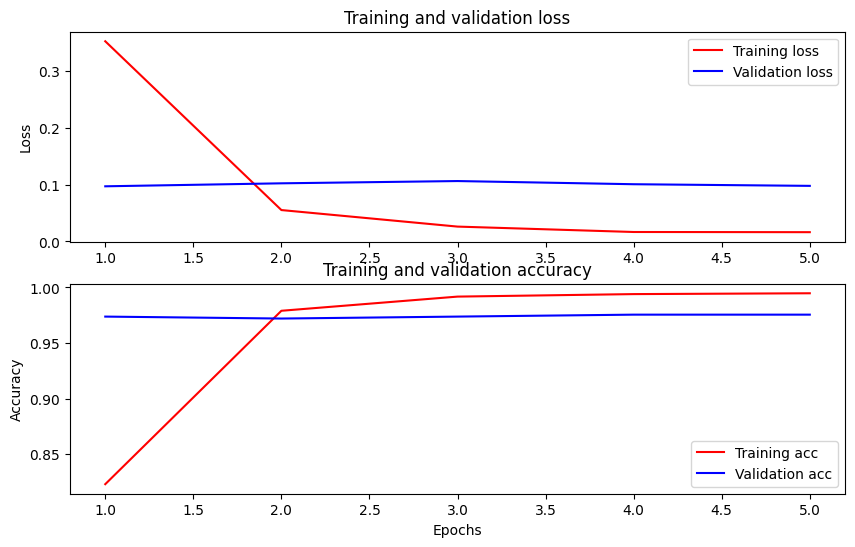

In [1]:
!pip3 install --quiet tensorflow-text numpy pandas tf-models-official

import csv
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_text as text # needed even if unused
import time

import matplotlib.pyplot as plt

def change_labels(x):
    return 1 if x == "spam" else 0

data = pd.read_csv(
    "./input/MatrixData.tsv", sep="\t", quoting=csv.QUOTE_NONE, encoding="utf-8"
)

# Minimum length
data = data[data["message"].str.split().str.len().gt(18)]
# Remove unknown
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data["label"] = data["label"].apply(change_labels)

# Remove stopwords
#data["message"] = data["message"].apply(remove_stopwords)
# Shuffle data
data = data.sample(frac=1).reset_index(drop=True)

# Split data into messages and label sets
sentences = data["message"].tolist()
labels = data["label"].tolist()

# Separate out the sentences and labels into training and test sets
# training_size = int(len(sentences) * 0.8)
training_size = int(len(sentences) * 0.7)
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
test_labels = np.array(testing_labels)
train_labels = np.array(training_labels)
train_examples = np.array(training_sentences)
test_examples = np.array(testing_sentences)

# Build dataset
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices((train_examples,train_labels))
print(f"raw_train_ds: {raw_train_ds}")

train_ds = raw_train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
print(f"train_ds: {train_ds}")
raw_val_ds = tf.data.Dataset.from_tensor_slices((test_examples,test_labels))
print(f"raw_val_ds: {raw_val_ds}")
val_ds = raw_val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

for text_batch, label in raw_train_ds.take(1).cache():
  print(f'Message: {text_batch}')
  print(f'Label: {label}')



# Load the BERT encoder and preprocessing models
# Alternative https://tfhub.dev/google/electra_small/2
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/google/electra_small/2'

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


classifier_model = build_classifier_model()
classifier_model.summary()
# bert_raw_result = classifier_model(tf.constant(sentences))
# print(tf.sigmoid(bert_raw_result))
tf.keras.utils.plot_model(classifier_model, show_dtype=True)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


saved_model_path = f'./bert_models/{time.time()}'

classifier_model.save(saved_model_path, include_optimizer=False)


